Data shape: (1921, 20)

==> Training LSTM for subsystem: hydraulic


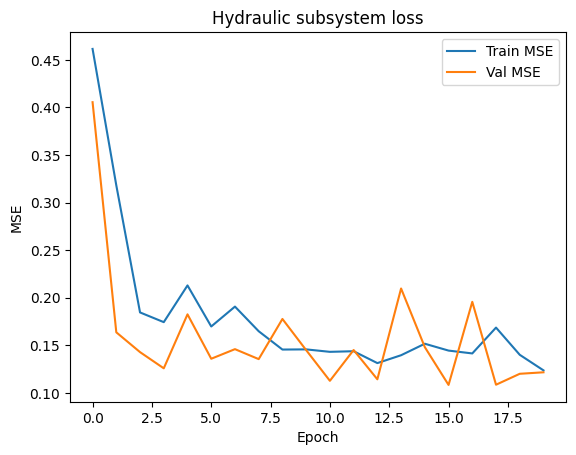


==> Training LSTM for subsystem: electrical


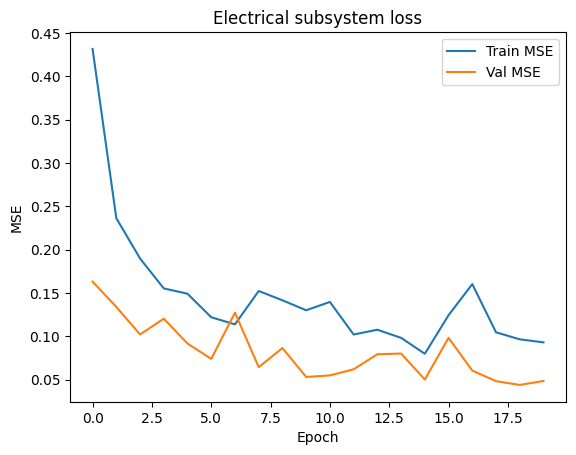


==> Training LSTM for subsystem: control_surface


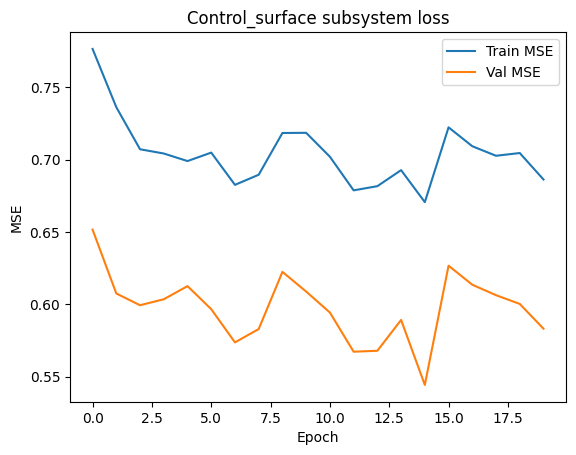


==> Training LSTM for subsystem: cabin


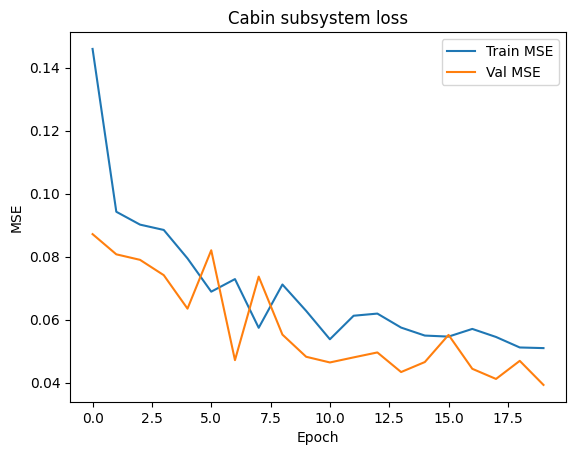


==> Training LSTM for subsystem: altimeter


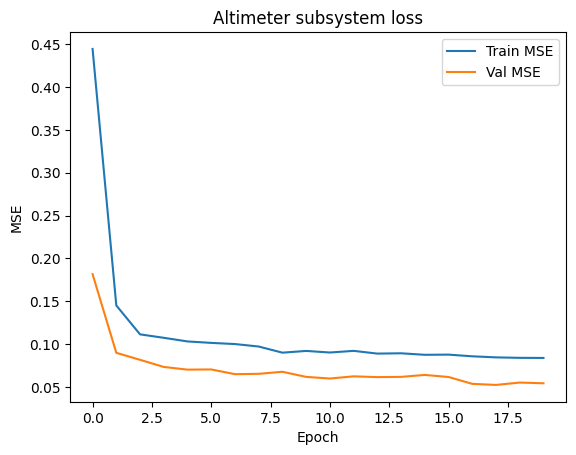


Final train/val MSE per subsystem:
                 final_train_MSE  final_val_MSE
subsystem                                      
hydraulic               0.123630       0.121602
electrical              0.092893       0.048310
control_surface         0.686335       0.583171
cabin                   0.050997       0.039318
altimeter               0.083833       0.054261


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# ——— 1. Load the data ———
df = pd.read_csv('synthetic_per_subsystem_train.csv')
print("Data shape:", df.shape)

# ——— 2. Define subsystems and their sensor columns ———
subsystems = {
    'hydraulic':       ['hydraulic_pressure', 'hydraulic_flow', 'hydraulic_temp'],
    'electrical':      ['electrical_voltage', 'electrical_current'],
    'control_surface': ['control_surface_deflection'],
    'cabin':           ['cabin_pressure'],
    'altimeter':       ['altimeter_drift']
}

SEQ_LEN    = 50
EPOCHS     = 20
BATCH_SIZE = 32
DEVICE     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ——— Dataset wrapper ———
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ——— LSTM model ———
class LSTMRegressor(nn.Module):
    def __init__(self, in_features, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(in_features, hidden_size, batch_first=True)
        self.out  = nn.Linear(hidden_size, 1)
    def forward(self, x):
        seq_out, _ = self.lstm(x)       # (batch, seq_len, hidden_size)
        last_step = seq_out[:, -1, :]   # (batch, hidden_size)
        return self.out(last_step).squeeze()

# ——— Training loop per subsystem ———
results = []
for name, features in subsystems.items():
    print(f"\n==> Training LSTM for subsystem: {name}")

    # 1) Subset the relevant columns plus unit/cycle and RUL_<name>
    target_col = f"RUL_{name}"
    keep_cols  = ['unit','cycle'] + features + [target_col]
    sub_df     = df[keep_cols].dropna().reset_index(drop=True)

    # 2) Global scaling
    feat_scaler = StandardScaler().fit(sub_df[features])
    targ_scaler = StandardScaler().fit(sub_df[[target_col]])
    sub_df[features] = feat_scaler.transform(sub_df[features])
    sub_df[target_col] = targ_scaler.transform(sub_df[[target_col]])

    # 3) Build sliding windows **within each unit**
    X_windows, y_windows = [], []
    for unit_id, grp in sub_df.groupby('unit'):
        grp = grp.sort_values('cycle')
        vals = grp[features].values
        tars = grp[target_col].values
        for i in range(len(grp) - SEQ_LEN):
            X_windows.append(vals[i:i+SEQ_LEN])
            y_windows.append(tars[i+SEQ_LEN])
    X = np.stack(X_windows)     # (n_seq, SEQ_LEN, n_features)
    y = np.array(y_windows)     # (n_seq,)

    # 4) Train/val split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True)

    train_ds = SequenceDataset(X_train, y_train)
    val_ds   = SequenceDataset(X_val,   y_val)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE)

    # 5) Instantiate model
    model     = LSTMRegressor(in_features=len(features)).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    train_losses, val_losses = [], []

    # 6) Train for EPOCHS
    for epoch in range(1, EPOCHS+1):
        # --- training ---
        model.train()
        batch_tr = []
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
            batch_tr.append(loss.item())
        train_losses.append(np.mean(batch_tr))

        # --- validation ---
        model.eval()
        batch_vl = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                batch_vl.append(criterion(model(xb), yb).item())
        val_losses.append(np.mean(batch_vl))

    # 7) Plot loss curves
    plt.figure()
    plt.plot(train_losses, label='Train MSE')
    plt.plot(val_losses,   label='Val MSE')
    plt.title(f"{name.capitalize()} subsystem loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()

    # 8) Record results (inverse‐scale MSE if you like)
    results.append({
        'subsystem': name,
        'final_train_MSE': train_losses[-1],
        'final_val_MSE':   val_losses[-1]
    })

# ——— Summary table ———
print("\nFinal train/val MSE per subsystem:")
print(pd.DataFrame(results).set_index('subsystem'))
